In [3]:
# 参考文献
# https://www.dataquest.io/blog/introduction-to-ensembles/
# https://www.jianshu.com/p/eb5a8f1e9f8b

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

df = pd.read_csv('input.csv')
df.head()

# 该数据集是关于美国民主党和共和党历年来的捐赠信息：其中第一列 cand_pty_affiliation 为我们接下来要预测的标签，即民主党和共和党，一个典型的二分类任务。

# 特征列中，
# entity_tp 表示个人还是组织
# classification 表示捐赠的领域
# rpt_tp 为贡献的等级
# 等等
# 以及数值型特征：

# cycle 表示捐赠在哪年
# transaction_amt 表示捐增的金额

,cand_pty_affiliation,cand_office_st,cand_office,cand_status,rpt_tp,transaction_tp,entity_tp,state,classification,cycle,transaction_amt
0,REP,US,P,C,Q3,15,IND,NY,Engineer,2016.0,500.0
1,DEM,US,P,C,M5,15E,IND,OR,Math-Stat,2016.0,50.0
2,DEM,US,P,C,M3,15,IND,TX,Scientist,2008.0,250.0
3,DEM,US,P,C,Q2,15E,IND,IN,Math-Stat,2016.0,250.0
4,REP,US,P,C,12G,15,IND,MA,Engineer,2016.0,184.0


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

SEED = 666   # 数据再现用
np.random.seed(SEED)

def get_train_test(test_size=0.95):   # 为了更快得到结果，训练集只用了5%数据，
    y = 1 * (df.cand_pty_affiliation == "REP")   # 使用 1 表示 REP 政党，使用 0 表示 DEM 政党
    X = df.drop(["cand_pty_affiliation"], axis=1)
    # 对分类型变量进行编码处理
    X = pd.get_dummies(X)
    return train_test_split(X, y, test_size=test_size, random_state=SEED)

xtrain, xtest, ytrain, ytest = get_train_test()  # 注意顺序
xtrain.shape

(5000, 158)

In [3]:
# 训练集的标准差
xtrain.std().sort_values()

# 158 个特征中存在很多标准差为 0 的特征，也就是训练集样本中这些特征的值都是一样的，
# 整个数据集中基本上所有样本的这些特征也都是相等的。

# 值都一样，对于分类任务，这些特征自然也就没有意义啦~接下来，就把标准差为 0 的特征 DROP 掉。
drop_columns = xtrain.columns[xtrain.std() == 0]
drop_columns

# 将训练集和测试集中的这些列全部删除
xtrain.drop(drop_columns, axis=1, inplace=True)
xtest.drop(drop_columns, axis=1, inplace=True)
xtrain.head()

ytrain.head()

2337     1
76735    1
74508    0
57640    0
39640    0
Name: cand_pty_affiliation, dtype: int64

<AxesSubplot:title={'center':'Share of No. donations'}>

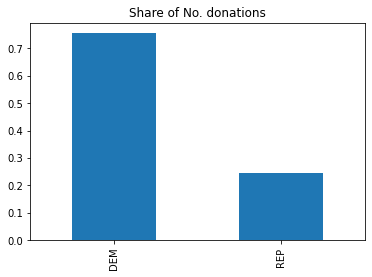

In [4]:
# 看一下原始数据集中正负样本分布情况：

y_counts = df.cand_pty_affiliation.value_counts(normalize=True)  # normalize=True显示计数占比
y_counts.plot(kind='bar', title="Share of No. donations")

Text(0.5, 1.0, 'over sample train dataset')

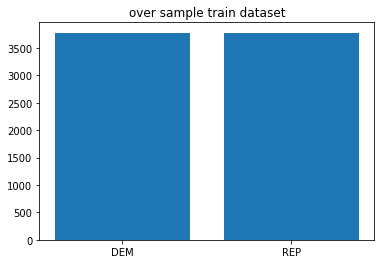

In [5]:
# 平衡正负样本数量，使模型在训练时学习到的正负样本数量一样多，从而做出更客观的决断
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=SEED)
x_over_sample_train, y_over_sample_train = smote.fit_resample(xtrain, ytrain)
plt.bar(['DEM', 'REP'],y_over_sample_train.value_counts())
plt.title('over sample train dataset')

Decision tree ROC-AUC score:  0.6243616070247398


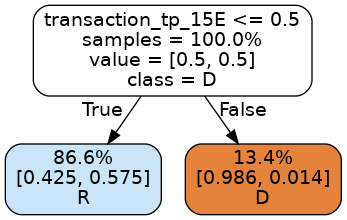

In [6]:
import pydotplus
from IPython.display import Image
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

def print_graph(clf, feature_names):
    """pringt decision tree"""
    graph = export_graphviz(clf, label="root", proportion=True, impurity=False, out_file=None, 
                            feature_names=feature_names, class_names={0: "D", 1: "R"}, filled=True, rounded=True)
    graph = pydotplus.graph_from_dot_data(graph)
    return Image(graph.create_png())

# sklearn.tree.export_graphviz 的参数 class_names 可以指定决策树分类标签使用的绘制名称；
# clf 为训练好的决策树模型。

# 要求系统安装graphviz，登录到linux服务器终端（可经宝塔）
# 代码：sudo su (进入root目录)
# sudo apt-get install graphviz （安装，见到Y，输入Y即可）
# which dot  （查看安装路径，显示路径表示安装成功，如/usr/bin/dot）

# 绘制深度为1的决策树
t1_o = DecisionTreeClassifier(max_depth=1, random_state=SEED)
t1_o.fit(x_over_sample_train, y_over_sample_train)
p_o = t1_o.predict_proba(xtest)[:,1]

print("Decision tree ROC-AUC score: ", roc_auc_score(ytest, p_o))
print_graph(t1_o, x_over_sample_train.columns)

# 决策树根节点中的 transation_tp_15E <=0.5 指出了该节点分类时使用的判断条件，value 表示正负样本的占比。
# 叶子节点中，第一行百分比表示有多少样本落在了当前节点：
# 经过根节点的切分，86.6% 的样本落在了左子树，13.4% 的样本落在了右子树。
# 第二行，即 value 值，表示正负样本占比情况：左边的叶子节点中，标签 0 占比为 0.425，标签 1 占比为 0.575，
# 因此左边的叶子节点被判定为标签 1 类型，即 R，已经在第三行为我们标识出来了。

Decision tree ROC-AUC score:  0.7543814772596693


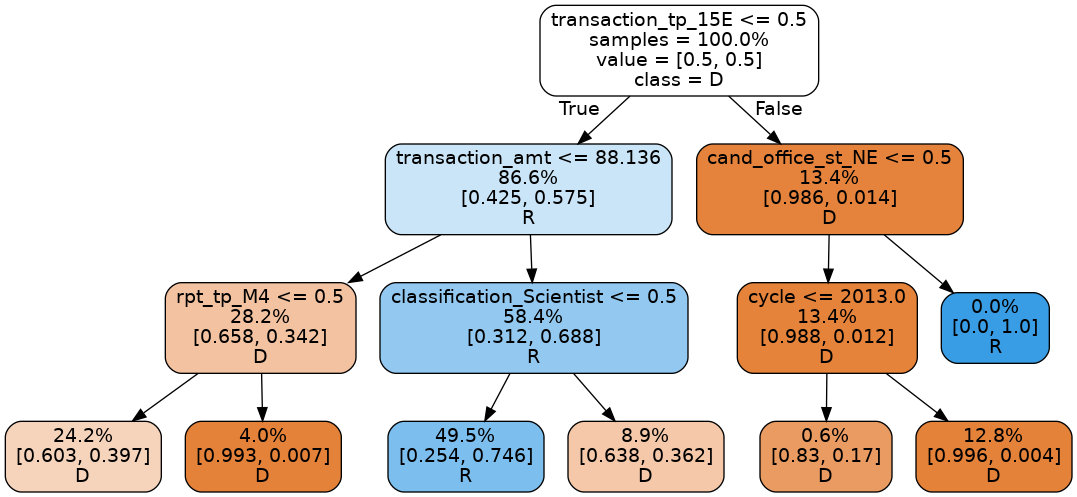

In [7]:
# 绘制深度为3的决策树
t2_o = DecisionTreeClassifier(max_depth=3, random_state=SEED)
t2_o.fit(x_over_sample_train, y_over_sample_train)
p_o = t2_o.predict_proba(xtest)[:,1]

print("Decision tree ROC-AUC score: ", roc_auc_score(ytest, p_o))
print_graph(t2_o, x_over_sample_train.columns)

Decision tree ROC-AUC score: 0.765


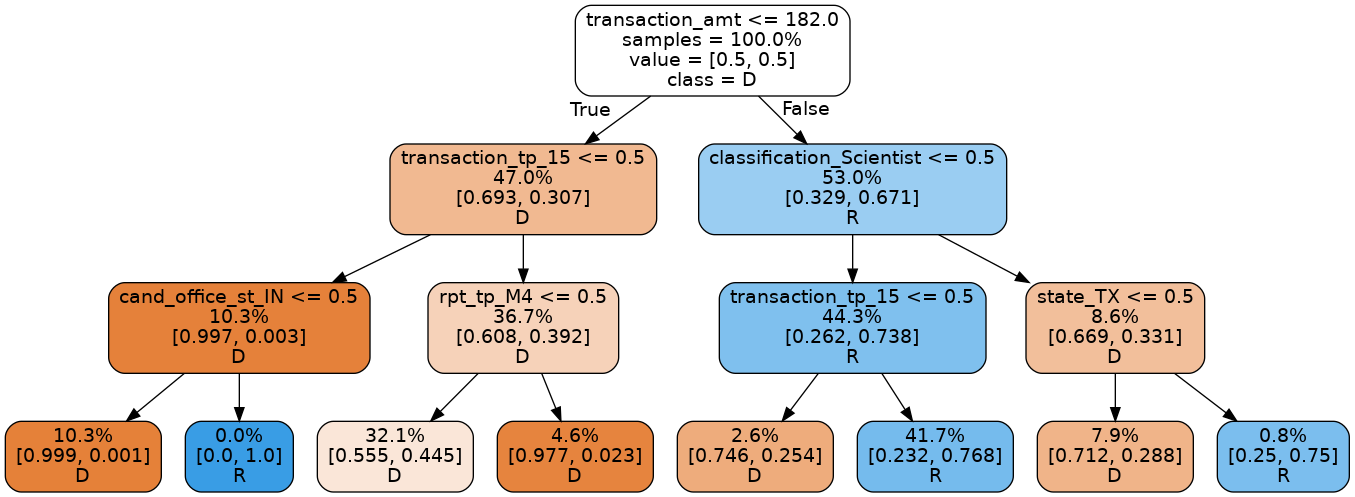

In [8]:
# 上述决策树中，有个叶子节点非常醒目，有 49.8% 的样本都落到了该叶子节点；
# 还有最左侧的叶子节点，23.9% 的样本也落在了该叶子节点上。
# 此时的模型过拟合的风险是比较大的，因为它很可能过度地关注某一个特征，而忽视了其它特征。
# 我们希望模型在做决策时，充分考虑所有特征，群策群力，而不是过分依赖某个特征，这样的模型是片面的。
# 尝试去掉对结果响应最大的特征 transaction_tp_15E 看看：

drop = ["transaction_tp_15E"]

xtrain_slim_o = x_over_sample_train.drop(drop, axis=1)
xtest_slim = xtest.drop(drop, axis=1)

t3_o = DecisionTreeClassifier(max_depth=3, random_state=SEED)
t3_o.fit(xtrain_slim_o, y_over_sample_train)
p = t3_o.predict_proba(xtest_slim)[:, 1]

print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t3_o, xtrain_slim_o.columns)

In [9]:
# 两棵树的ROC-AUC Score 值基本一致，评估结果差不多；
# 但决策树的内部构造确是完全不同的，可以说它们各自有各自的错误，也各自有各自的优点，
# 那我们何不综合这两棵树来得出最终的预测呢？

p1_o = t2_o.predict_proba(xtest)[:, 1]
p2_o = t3_o.predict_proba(xtest_slim)[:, 1]
p = np.mean([p1_o, p2_o], axis=0)

print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

# p一平均 ROC-AUC 的值还真的提高了！
# 可见，选择不同的特征会产生不同的结果，然后用不同的结果进行组合得到了一个升华！
# 那让我们多选几组不就是随机森林了吗？

# 使用随机森林构造 100 棵不同的决策树，评估结果

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_features=3, random_state=SEED)
rf.fit(x_over_sample_train, y_over_sample_train)
p_o = rf.predict_proba(xtest)[:, 1]

print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p_o))

# 使用随机森林建模的 ROC-AUC Score 值又有了显著的提升！这就是 Bagging 集成思想的魅力~

Average of decision tree ROC-AUC score: 0.773
Average of decision tree ROC-AUC score: 0.869


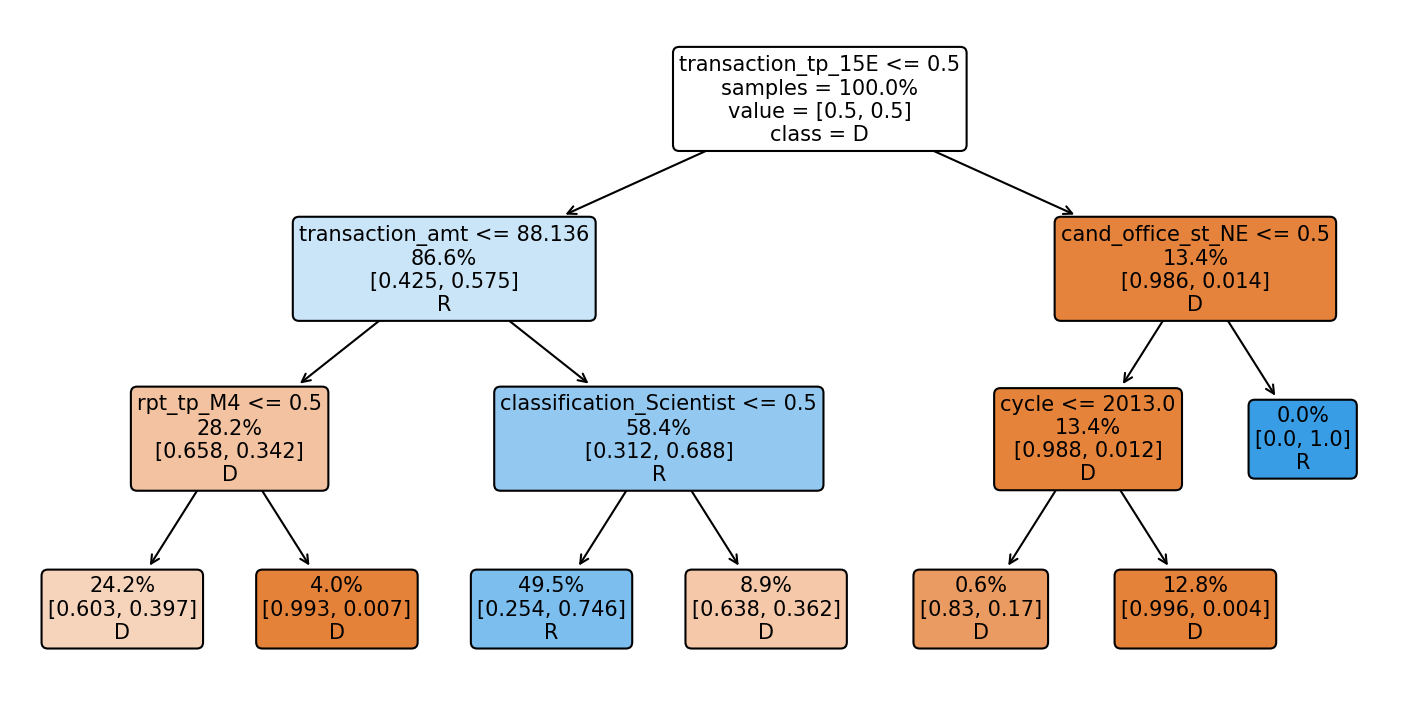

In [10]:
# 使用sklearn自带的工具绘制决策树, impurity为True则显示gini系数
from sklearn import tree
import matplotlib.pyplot as plt

fig, axe = plt.subplots(figsize=(12,6), dpi=150)
# 使用sklearn自带的工具绘制决策树, impurity为True则显示gini系数
tree.plot_tree(t2_o, filled=True, ax=axe, proportion=True, rounded=True, impurity=False, label='root', 
              feature_names=xtrain.columns, fontsize=10, class_names={0:'D', 1:'R'});

In [ ]:
# 我们分别使用决策树、以及随机森林实现了建模，并最终在未进行任何调参的情况下，
# 使用随机森林得到了 0.869 的 ROC-AUC Score 值。
# 其中，随机森林其实就是 Bagging 的集成思想，通过构造一批不同的决策树，来综合考虑每棵树的结果，得到最终的值。
# 相比于单棵树，结果得到了更大的提升，不仅泛化能力强，过拟合风险小，而且大幅提升了模型的准确性。
# 今天，我们将进一步提升模型的泛化能力以及准确性。随机森林的基础模型都是决策树，
# 那我们是否可以使用不同的算法，构造出不同的基础模型呢？如 KNN，LR，SVM，RF 等等。
# 最后将所有模型得到的预测结果取平均，做为最终的预测值

# 导入各种分类器
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# 构建基础模型，并以字典形式返回
def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    svc = SVC(C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=100, random_state=SEED, solver="liblinear")
    nn = MLPClassifier((80,10), early_stopping=False, random_state=SEED)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    rf = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=SEED)
    
    models = {
        "svm":svc,
        'knn': knn,
        'naive bayes': nb,
        'mlp-nn': nn,
        'random forest': rf,
        'gbm': gb,
        'logistic': lr,
    }
    
    return models

# 训练模型
def train_predict(models):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(models)))
    P = pd.DataFrame(P)
    
    print("Fitting models.")
    cols = list()
    
    for i, (name, m) in enumerate(models.items()):
        print("{} ...".format(name), end=" ", flush=False)
        m.fit(x_over_sample_train, y_over_sample_train)
        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        cols.append(name)
        print("done")
        
    P.columns = cols
    print("Fitting models Done.")
    return P

# 其中 P 用来存放所有模型的预测结果，P 中的行对应测试集中每个样本通过不同的模型预测的结果值，
# 列为具体的算法模型的所有预测值。因此，测试集有多少个样本，P 就有多少行；有多少个模型，P 就有多少列。
# 接下来，就是使用 for 循环，分别使用不同的模型进行训练以及预测，并将预测结果保存在 P 中。
# 此处没有并行地训练多个分类器，一方面小鱼训练集的数据比较少，另一方面呢，没有交叉验证，调参的过程。
# 最后，将预测结果 P 进行返回。
# 拿到预测结果的组合 P 之后，就可以分别计算各模型的 AUC-ROC Score 啦~


def score_model(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    s = pd.Series()
    
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        s.loc[m] = score
        
    print(s.sort_values())
    print("Scoring models Done.")
    
models = get_models()
P = train_predict(models)

Fitting models.
svm ... done
knn ... 

In [ ]:
score_model(P, ytest)

P.head()

# 通过计算 P 的相关系数，可以了解各模型之间的相似层度：
P.corr()

# 借助ML-Ensemble 为我们提供的可视化工具来直观地观察出模型的相似层度
from mlens.visualization import corrmat
corrmat(P.corr(), inflate=False)


# 通过观察相关性矩阵，可以发现 mlp-nn 模型、gbm 模型以及 logistic 模型的相关度是比较高的。


# 计算所有模型预测的结果
print("Ensemble ROC-AUC score: %.3f" % roc_auc_score(ytest, P.mean(axis=1)))

# 在 bagging 集成时，通过集成不同算法类型的模型，获得的结果值又得到了提升。
# 可见，继承算法一方面可以使得边界更平稳，降低过拟合的风险，提高模型的泛化能力；
# 另一方面可以有效地提高模型的评分。

In [ ]:
# ROC曲线
from sklearn.metrics import roc_curve

def plot_roc_curve(ytest, P_base_learners, P_ensemble, labels, ens_label):
    """Plot the roc curve for base learners and ensemble."""
    plt.figure(figsize=(5, 4), dpi=120)
    plt.plot([0, 1], [0, 1], 'k--')
    
    cm = [plt.cm.rainbow(i) for i in np.linspace(0, 1.0, P_base_learners.shape[1] + 1)]
    
    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:, i]
        fpr, tpr, _ = roc_curve(ytest, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])

    fpr, tpr, _ = roc_curve(ytest, P_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c=cm[0])
        
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(frameon=False)
    plt.show()
    
    
# 上述代码中，plt.plot([0, 1], [0, 1], 'k--') 在 （0,0）和（1,1）之间绘制一条虚线，
# 表示随机的预测结果。ROC 曲线基本会分布在该曲线上方。
# cm 为绘制不同模型的 ROC 曲线时使用的 Clolor Map。plt.plot() 绘图时，
# 首先使用 for 循环绘制了所有的基础模型的 ROC 曲线，之后单独绘制集成模型的 ROC 曲线。
# from sklearn.metrics import roc_curve 可以根据真实值和预测值，
# 计算出 False Positive Rate 和 True Positive Rate。

plot_roc_curve(ytest, P.values, P.mean(axis=1), list(P.columns), "ensemble")

# emsemble 曲线既平滑，面积又是最大的！此外，逻辑回归作为机器学习中最简单的模型，结果也是非常棒的。
# 在机器学习中，模型并非越复杂越好，逻辑回归也是一把宝刀~



In [1]:
# 基础模型有的预测结果好，有的预测能力一般，如果只是简单粗暴地将结果取平均值，是不公平的。
# Bagging 中存在的问题
# 比如，其中有的基础模型会将大部分样本预测为多数类别，存在过拟合的风险。
# 这一点，可以分析一下各模型预测结果中正负样本的分布情况。

p = P.apply(lambda x:1*(x>=0.5).value_counts(normalize=True))
p.index = ["DEM", "REP"]
p

# 测试集真实的分布情况：
ytest.value_counts(normalize=True)


# 可视化的方式看一下少数类别的预测结果：

p.loc["REP",:].sort_values().plot(kind="bar")

plt.axhline(0.24, color="g", linewidth=1, alpha=0.3)
plt.title("REP FOR PREDICT")
plt.show()

# 从比例上来看，mlp-nn 和 logistic 将大部分样本预测成了多数类别 DEM ，
# 因而少数类别占比较小。下面，尝试去掉 mlp-nn 来看下预测结果：

include = [c for c in P.columns if c not in ["mlp-nn"]]
print("Truncated ensemble ROC-AUC score: %.3f" % roc_auc_score(ytest, P.loc[:,include].mean(axis=1)))

# 效果似乎没有得到改善，反而变得糟糕了。
# 这其实是因为每个算法模型有自己的缺点的同时，也存在优点，简单去掉的话并不是一个恰当的方式。


# 绘制各个基础模型预测结果的混淆矩阵，并打印召回率。
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10,12), dpi=200)
j = 1

for i in range(len(P.columns)):
    model_name = P.columns[i]
    cnf_matrix = confusion_matrix(ytest, P.iloc[:,i]>0.5)
    
    recall = cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
    print(f"模型 {model_name} 的召回率为 {recall:.2%}。")
    
    plt.subplot(4,2,j)
    plt.title(model_name)
    sns.heatmap(cnf_matrix,annot=True,fmt='g')
    j += 1
    
    
# 可以发现 mlp-nn 和 logistic 的召回率确实是很低的，只有 51% 。
# 召回率不是我们评估模型的唯一标准，召回率高表示漏网之鱼少，还须要考虑到误杀的样本。
# 因此，下面我们尝试使用 ROC-AUC Score 来淘汰两个模型。
# 从曲线下方面积（AUC 面积）来看，我们需要淘汰掉的是 svm 和 naive bayes

include = [c for c in P.columns if c not in ["svm", "naive bayes"]]
print("Truncated ensemble ROC-AUC score: %.3f" % roc_auc_score(ytest, P.loc[:,include].mean(axis=1)))

# ROC-AUC Score 由原来的 0.880 提升到了 0.884 。

NameError: name 'P' is not defined

In [ ]:
#　Stacking 集成
# 对于每一个基础模型，选择一个最合适的权重，但是这些权重我们来怎么定义呢？
# 那就让我们训练一个模型来定义这些权重吧！也就是说我们将基础模型预测的结果输入到另一个模型中，
# 比如 LR 构建的分类器，这样对于每个基础分类器的预测结果，就可以乘以一个合理的权重值，
# 能力强的基础分类器权重比例自然大，能力弱的分类器权重小。

# 定义基础模型（第一阶段）
base_learners = get_models()


# 定义权重分配模型（第二阶段）
meta_learner = GradientBoostingClassifier(
    n_estimators=1000,
    loss="exponential",
    max_features=4,
    max_depth=3,
    subsample=0.5,
    learning_rate=0.005, 
    random_state=SEED
)
# GradientBoostingClassifier 分类器，大家可以尝试其它的分类器。


# 切分训练集数据
# 将基础模型中的训练集分成两部分：train_base 和 pred_base，
# train_base 用来训练各个基础模型，xpred_base 输入基础模型，获得第一阶段的预测值；
# 将第一阶段预测结果作为第二阶段模型的输入，ypred_base 作为第二阶段训练模型时的 y 。
# 注：第一阶段训练时使用过的数据，同时拿去做预测并将预测结果作为第二阶段的输入是毫无意义的。


xtrain_base, xpred_base, ytrain_base, ypred_base = train_test_split(x_over_sample_train, y_over_sample_train, 
                                                                    test_size=0.5, random_state=SEED)

# 训练基础模型
def train_base_learners(base_learners, x, y, verbose=True):
    """Train all base learners in the library."""
    if verbose: 
        print("Fitting models.")
    
    for i, (name, m) in enumerate(base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        m.fit(x, y)
        if verbose: print("done")
            

# 训练基础模型时，使用的训练集 x y 分别为 xtrain_base 和 ytrain_base：
train_base_learners(base_learners, xtrain_base, ytrain_base)


# 下面，我们来定义基础训练器的结果预测函数：
# 其中，预测结果 P 的行数和预测样本的个数一致，列数则和基础训练器的个数相同，
# P 将作为第二阶段模型的输入特征。

def predict_base_learners(pred_base_learners, x, verbose=True):
    """Generate a prediction matrix."""
    P = pd.DataFrame(np.zeros((x.shape[0], len(pred_base_learners))), columns=pred_base_learners.keys())
    if verbose:
        print("Generating base learner predictions.")
    
    for i, (name,model) in enumerate(pred_base_learners.items()):
        if verbose:
            print("%s..." % name, end=" ", flush=False)
        p = model.predict_proba(x)
        P[name] = p[:,1]
        if verbose: 
            print("done")

    return P

# 将训练好的 base_learns 和 xpred_base 作为参数传入上述函数，得到基础分类器的预测结果：

P_base = predict_base_learners(base_learners, xpred_base)


# 训练第二阶段的模型：


meta_learner.fit(P_base, ypred_base)
GradientBoostingClassifier(learning_rate=0.005, loss='exponential',
                           max_features=4, n_estimators=1000, random_state=666,
                           subsample=0.5)



# 定义函数 ensemble_predict 函数实现 Stacking 集成，
# 先由基础模型进行预测得到 P_pred ，再有第二阶段模型 meta_learner 进行预测得到最终结果。

def ensemble_predict(base_learners, meta_learner, x, verbose=True):
    """Generate predictions from the ensemble."""
    P_pred = predict_base_learners(base_learners, x, verbose)
    return P_pred, meta_learner.predict_proba(P_pred)[:, 1]


# 在测试集上进行预测，并计算 ROC-AUC Score：

P_pred, p = ensemble_predict(base_learners, meta_learner, xtest)
print(f"\nEnsemble ROC-AUC score: {roc_auc_score(ytest, p):.3}")


# 经过 Stacking 集成之后，ROC-AUC Score 由 0.880 提升到了 0.883，有提升，提升不多。
# 我们可以想想上述六个步骤中，哪个步骤需要我们优化呢？
# 其实是第三步，切分训练集数据，将原训练集的数据一分为二之后，
# 无论是训练基础模型，还是训练第二阶段的权重分配模型时，训练集数据都少了一半，这是非常浪费的。
# 那有没有什么方法既可以保证每次训练基础模型和训练权重分配模型的数据不同，而且不浪费任何数据呢？


# 交叉验证 （参考https://www.jianshu.com/p/31f193f78699）
# 注：在进行交叉验证时，每组在训练基础模型时，必须使用全新的基础模型，而不是上一组训练过的模型。


from sklearn.base import clone

def stacking(base_learners, meta_learner, X, y, kfold):
    """Simple training routine for stacking."""
    # Train final base learners for test time
    print("Fitting Final Base Learners...", end="")
    train_base_learners(base_learners, X, y, verbose=False)
    print("Done")
    
    # Generate predictions for training meta learners
    cv_preds, cv_y = [], []
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        fold_xtrain, fold_ytrain = X.iloc[train_index,:], y.iloc[train_index]
        fold_xtest, fold_ytest = X.iloc[test_index,:], y.iloc[test_index]
        
        fold_base_learners = {name: clone(model) for name, model in base_learners.items()}
        
        train_base_learners(fold_base_learners, fold_xtrain, fold_ytrain, verbose=False)
        fold_P_base = predict_base_learners(fold_base_learners, fold_xtest, verbose=False)
        
        cv_preds.append(fold_P_base)
        cv_y.append(fold_ytest)
        
        print(f"CV Fold {i+1} Done")
    
    print("CV-Predictions Done")
    
    # Be careful to get rows in the right order
    cv_preds = pd.concat(cv_preds)
    cv_y = pd.concat(cv_y)
    
    # Train meta learner
    print("Fitting Meta Learner...", end="")
    meta_learner.fit(cv_preds, cv_y)
    print("Done")
    
    return base_learners, meta_learner

# 函数有点长，小鱼一点一点来为大家解读，也可以借此机会再理解一下 Stacking 集成。
# stacking 函数返回值为第一阶段训练好的基础分类器 base_learners 和 第二阶段训练好的权重分配分类器 meta_learner。

# 根据返回值的需求，我们的 stacking 函数也分成两部分：

# 训练基础分类器
# 训练第二阶段分类器
# 其中，Stacking 接收的参数依次为基础模型 base_learners 、第二阶段的初始化算法模型 meta_learner 、
# 原始训练集特征 X 、原始训练集标签 y 以及 K折的交叉验证对象 kfold 。

# 训练基础分类器的代码：


print("Fitting Final Base Learners...", end="")
train_base_learners(base_learners, X, y, verbose=False)
print("Done")


# 由于我们接下来马上会使用交叉验证构建第二阶段的输入，因此训练第一阶段的模型时，放心地使用全部的训练集数据 X 和 y 就好。

# 然后就是 CV 构造第二阶段输入的代码了：


cv_preds, cv_y = [], []
for i, (train_index, test_index) in enumerate(kfold.split(X)):
    fold_xtrain, fold_ytrain = X.iloc[train_index,:], y.iloc[train_index]
    fold_xtest, fold_ytest = X.iloc[test_index,:], y.iloc[test_index]

    fold_base_learners = {name: clone(model) for name, model in base_learners.items()}

    train_base_learners(fold_base_learners, fold_xtrain, fold_ytrain, verbose=False)
    fold_P_base = predict_base_learners(fold_base_learners, fold_xtest, verbose=False)

    cv_preds.append(fold_P_base)
    cv_y.append(fold_ytest)

    print(f"CV Fold {i+1} Done")

    
# 使用 kfold.split(x) 切分特征，遍历每组结果时，可以分别得到每组数据的训练集索引 train_index 和验证集索引 test_index ，
# 使用位置索引 iloc 即可选出每组数据的训练集和测试集。

fold_xtrain, fold_ytrain = X.iloc[train_index,:], y.iloc[train_index]
fold_xtest, fold_ytest = X.iloc[test_index,:], y.iloc[test_index]

# 接下来的一行代码也非常关键：
fold_base_learners = {name: clone(model) for name, model in base_learners.items()}



# 对于交叉验证的每组训练，必须使用 clone 函数克隆出一组全新的基础模型，这些全新的模型没看过任何训练集数据，就和刚初始化时一样。
# 然后使用这些全新的基础模型 fold_base_learners 进行模型的训练，并预测第一阶段结果。
train_base_learners(fold_base_learners, fold_xtrain, fold_ytrain, verbose=False)
fold_P_base = predict_base_learners(fold_base_learners, fold_xtest, verbose=False)


# 最后将该组数据第一阶段预测值和对应的真实值保存下来，完成 1 次 for 循环。
cv_preds.append(fold_P_base)
cv_y.append(fold_ytest)



# for 循环结束后，分别将交叉验证的所有结果、真实值各自拼接起来，用于二阶段权重分配模型的训练：

# Be careful to get rows in the right order
cv_preds = pd.concat(cv_preds)
cv_y = pd.concat(cv_y)

# Train meta learner
print("Fitting Meta Learner...", end="")
meta_learner.fit(cv_preds, cv_y)
print("Done")


# 调用上述 stacking 函数，参数 kfold 为 2 折交叉验证：

from sklearn.model_selection import KFold
cv_base_learners, cv_meta_learner = stacking(
    get_models(), clone(meta_learner), 
    x_over_sample_train, y_over_sample_train, 
    KFold(2)
)

P_pred, p = ensemble_predict(cv_base_learners, cv_meta_learner, xtest, verbose=False)
print(f'\nEnsemble ROC-AUC score: {roc_auc_score(ytest, p):.3}')



# 输出结果反而下降了？其实，这里是因为小鱼想快点得到结果，所以只使用了 2 折的交叉验证，
# 试想一下，对于 2 折的交叉验证，每次训练基础模型时，只用了一半的数据。
# 我们在测试集、训练集划分时多采用 8:2 、7:3 这样的比例，以保证训练集的数据更充分。
# 下面直接使用 mlens.ensemble 模块下的 SuperLearner 来进行并行地交叉验证训练，指定 10 折的交叉验证，
# 这样每组交叉验证将会使用 90% 的数据作为训练集。
# 初始化并行训练的 SuperLearner ，并添加基础模型和第二阶段模型：

from mlens.ensemble import SuperLearner

# Instantiate the ensemble with 10 folds
sl = SuperLearner(
    folds=10,
    random_state=SEED,
    verbose=2,
    backend="multiprocessing"
)

# Add the base learners and the meta learner
sl.add(list(base_learners.values()), proba=True) 
sl.add_meta(meta_learner, proba=True)


# 使用 SuperLearner 进行训练和预测：

# Train the ensemble
sl.fit(x_over_sample_train, y_over_sample_train)

# Predict the test set
p_sl = sl.predict_proba(xtest)
print(f"\nSuper Learner ROC-AUC score: {roc_auc_score(ytest, p_sl[:, 1]):.3}")


# 至此，使用了交叉验证的 Stacking 集成就算完成了~
# 说明
# 细心的读者可能疑问：使用了交叉验证的 Stacking 集成和没使用之前结果一样，ROC-AUC Score 还是 0.883。
# 这是因为小鱼为了快速地得到结果，在 【实战篇】集成算法建模（一） 进行原始数据集切分的时候，
# 只取出 5% 的数据作为训练集，也就是 5000 条数据，过采样之后大概 6000 多条数据，所以训练集的数据整体就太小了。
# 最后，我们对比一下 Bagging 集成和 Stacking 集成的 ROC-AUC 曲线：

p_sl[:,1].reshape(-1,1).shape
P.mean(axis=1).shape
plot_roc_curve(ytest, p_sl[:,1].reshape(-1,1), P.mean(axis=1), ["Super Learner"], "Simple average")


# 从结果来看，似乎 Stacking 集成思想的 Super Learner 只比 Bagging 集成思想的 Simple Average 好一点点，甚至差不多。
# 其实，小鱼的集成算法建模系列文章中，未对特征做标准化、归一化等预处理操作，并且也没有进行细节的调参，
# 我们只是重点讲述了集成思想的应用。
# 感兴趣的读者朋友，可以尝试添加数据预处理和调参，再来对比 Bagging 和 Stacking 集成的效果，想必对比会更加明显。